In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import Ridge, ridge_regression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score,balanced_accuracy_score
import plotly.express as px
from umap import UMAP

#### Load the latent space from one model trained on UKB, on the right CINGULATE region

In [2]:
embeddings_UKB = pd.read_csv("/neurospin/dico/adufournet/Runs/01_Heritability_Right_PCS_HCP/Program/2024-04-24/10-50-27_36/UKB_epoch60_embeddings/full_embeddings.csv", index_col=0)
embeddings_UKB.head()

dim1       dim2       dim3       dim4       dim5       dim6  \
ID                                                                              
sub-1000021 -13.931313 -20.228790  -2.351910  22.903593   4.705052  18.064594   
sub-1000458 -27.508526 -22.464178  15.330263  -8.684494   1.744135  16.401610   
sub-1000575  -9.019172   5.081558  13.194763  -9.988724  -4.874171 -24.418629   
sub-1000606  -5.862392  -8.704276 -22.276031  20.907238   0.767730  14.855814   
sub-1000963 -25.473278   1.651641  -7.365778 -21.681479  18.501171  23.575530   

                  dim7       dim8       dim9      dim10  ...     dim247  \
ID                                                       ...              
sub-1000021  -0.727025 -17.399858  -6.217485  22.291307  ... -10.929922   
sub-1000458   7.456940 -21.850723  19.866627   8.797631  ...  -7.573163   
sub-1000575   6.633943 -24.712519  -5.238509  -1.482300  ...   5.858938   
sub-1000606 -11.449471  -9.651089  -9.755624  32.766630  ... -20.278133   
sub-1000963  -8.017796 -15.201870   5.839160   5.662610  ... -14.506186   

                dim248     dim249     dim250     dim251     dim252     dim253  \
ID                                                                              
sub-1000021   1.404516  -4.437763 -17.509428  10.602697 -14.881742  -0.646338   
sub-1000458   0.289662  16.776058  14.058151   7.748422 -18.693428 -30.020218   
sub-1000575 -25.280958   7.412261  12.342629  10.415935   4.523824  -7.905085   
sub-1000606  -2.978090 -14.676039  -8.346285  10.906873  21.820381  10.595843   
sub-1000963  10.651568   3.129409 -17.768148  -1.724178 -12.495091   2.465088   

                dim254     dim255     dim256  
ID                                            
sub-1000021  14.122347   0.847274  23.677437  
sub-1000458  30.022623 -14.871938   5.965506  
sub-1000575   6.157226 -18.156778 -15.436461  
sub-1000606   5.306481 -19.714754   6.550507  
sub-1000963  26.583134  12.387905  40.281150  

[5 rows x 256 columns]

#### Load the information about the ukb subjects (sex and age)

In [3]:
ukb_info = pd.read_csv('/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/participants_sex_age.csv')
ukb_info.head()

participant_id  Sex   Age
0    sub-3411469    1  65.0
1    sub-2290292    0  69.0
2    sub-3842391    0  70.0
3    sub-2758537    1  49.0
4    sub-4334619    1  70.0

In [4]:
ukb_volume=pd.read_csv('/volatile/ad279118/Runs/brain_segmentation_volume.csv',header=None, names=["ID", "Volume"])
ukb_volume

ID     Volume
0      sub-1000021  1310943.0
1      sub-1000325  1312205.0
2      sub-1000458  1377807.0
3      sub-1000575  1111215.0
4      sub-1000606  1229380.0
...            ...        ...
38026  sub-6023808  1117542.0
38027  sub-6023847   991646.0
38028  sub-6024150  1150009.0
38029  sub-6024379  1146007.0
38030  sub-6024754  1030743.0

[38031 rows x 2 columns]

#### Merge the two dataframes on the participant ID

In [17]:
ukb_fusion = embeddings_UKB.join(ukb_info.set_index('participant_id'), how='inner')
ukb_fusion = ukb_fusion.join(ukb_volume.set_index('ID'), how='inner')
ukb_fusion.head()

dim1       dim2       dim3       dim4       dim5       dim6  \
sub-1000021 -13.931313 -20.228790  -2.351910  22.903593   4.705052  18.064594   
sub-1000458 -27.508526 -22.464178  15.330263  -8.684494   1.744135  16.401610   
sub-1000575  -9.019172   5.081558  13.194763  -9.988724  -4.874171 -24.418629   
sub-1000606  -5.862392  -8.704276 -22.276031  20.907238   0.767730  14.855814   
sub-1000963 -25.473278   1.651641  -7.365778 -21.681479  18.501171  23.575530   

                  dim7       dim8       dim9      dim10  ...     dim250  \
sub-1000021  -0.727025 -17.399858  -6.217485  22.291307  ... -17.509428   
sub-1000458   7.456940 -21.850723  19.866627   8.797631  ...  14.058151   
sub-1000575   6.633943 -24.712519  -5.238509  -1.482300  ...  12.342629   
sub-1000606 -11.449471  -9.651089  -9.755624  32.766630  ...  -8.346285   
sub-1000963  -8.017796 -15.201870   5.839160   5.662610  ... -17.768148   

                dim251     dim252     dim253     dim254     dim255     dim256  \
sub-1000021  10.602697 -14.881742  -0.646338  14.122347   0.847274  23.677437   
sub-1000458   7.748422 -18.693428 -30.020218  30.022623 -14.871938   5.965506   
sub-1000575  10.415935   4.523824  -7.905085   6.157226 -18.156778 -15.436461   
sub-1000606  10.906873  21.820381  10.595843   5.306481 -19.714754   6.550507   
sub-1000963  -1.724178 -12.495091   2.465088  26.583134  12.387905  40.281150   

             Sex   Age     Volume  
sub-1000021    1  51.0  1310943.0  
sub-1000458    1  68.0  1377807.0  
sub-1000575    1  64.0  1111215.0  
sub-1000606    0  58.0  1229380.0  
sub-1000963    1  70.0  1195739.0  

[5 rows x 259 columns]

In [23]:
ukb_fusion.loc[['sub-5963962', 'sub-5001586', 'sub-3675637']]

dim1       dim2       dim3       dim4       dim5       dim6  \
sub-5963962  -1.180966  12.453327  21.312317  -2.892533  18.980436  13.155901   
sub-5001586  30.024414  20.051971   9.187108  -6.888497  12.452384  11.142262   
sub-3675637  -1.271609  -6.585759   8.316385  21.594688  10.606391  21.771105   

                  dim7       dim8       dim9      dim10  ...     dim250  \
sub-5963962   9.667461 -21.386185  27.879896  -9.202510  ...  19.185085   
sub-5001586 -17.586025 -33.006454   9.074867   4.474809  ...  24.750940   
sub-3675637   6.320830 -30.949831  16.904830  18.580341  ...   2.322569   

                dim251    dim252     dim253     dim254    dim255     dim256  \
sub-5963962  22.940496  0.779435 -16.176601  30.413963  1.843533  13.195145   
sub-5001586  14.657994  1.840169 -16.257378   7.802519 -0.842059  -8.546570   
sub-3675637  21.478365 -9.564703  -9.007757  22.395506 -7.386869   9.878303   

             Sex   Age    Volume  
sub-5963962    0  61.0  350216.0  
sub-5001586    0  51.0  375338.0  
sub-3675637    1  58.0   98405.0  

[3 rows x 259 columns]

In [46]:
ukb_fusion[ukb_fusion['Volume']<8e5]

dim1       dim2       dim3       dim4       dim5       dim6  \
sub-1146029  -9.278512  25.127209 -12.809571 -26.507650   5.299044 -13.784863   
sub-1366082  -8.017363   1.233495 -21.175161  -4.033348 -10.636720  10.290096   
sub-1832571  -6.855375  -1.463847  19.727283  22.419912  15.775330   5.982734   
sub-2927441  -2.639198   7.306437  -0.061145  -5.914402  15.619381 -15.943022   
sub-3044755  -1.425022   3.912715 -14.245232 -22.182910   1.021833  28.894762   
sub-3675637  -1.271609  -6.585759   8.316385  21.594688  10.606391  21.771105   
sub-3829981  14.935812 -13.973727   6.267316 -25.659788   1.678682  -0.360423   
sub-4030844 -13.978929 -21.224012 -12.530935  19.720660  -3.955216   5.307416   
sub-5001586  30.024414  20.051971   9.187108  -6.888497  12.452384  11.142262   
sub-5963962  -1.180966  12.453327  21.312317  -2.892533  18.980436  13.155901   

                  dim7       dim8       dim9      dim10  ...     dim250  \
sub-1146029 -16.320570 -31.385778 -12.129457  25.202278  ... -13.504403   
sub-1366082   1.070728  -8.262733  -0.007603  16.528835  ... -20.764599   
sub-1832571  27.909582 -15.833900  24.686260   3.319753  ...  25.112831   
sub-2927441  25.583757  -7.907404   0.658950   4.862631  ...  11.074127   
sub-3044755 -11.583997 -37.713623 -16.301792  11.282739  ... -12.184926   
sub-3675637   6.320830 -30.949831  16.904830  18.580341  ...   2.322569   
sub-3829981 -32.964874 -41.746880  19.414137   3.234798  ...  27.321598   
sub-4030844   4.239438 -28.070219  -8.382814  27.691418  ...  -1.680737   
sub-5001586 -17.586025 -33.006454   9.074867   4.474809  ...  24.750940   
sub-5963962   9.667461 -21.386185  27.879896  -9.202510  ...  19.185085   

                dim251     dim252     dim253     dim254     dim255     dim256  \
sub-1146029   3.220926  18.551128  24.613798  -0.606139  -8.863468 -18.748154   
sub-1366082  16.244493   2.195369  -2.819503  -2.569518   1.446263  -0.510694   
sub-1832571  17.899845  25.063622  -4.972964  27.199385 -26.948410   3.056195   
sub-2927441  12.451272  16.118946 -23.400928   4.952163  -4.392794 -14.603549   
sub-3044755  -0.016166  -6.612610  -5.054002  12.357545  -7.033843   0.708393   
sub-3675637  21.478365  -9.564703  -9.007757  22.395506  -7.386869   9.878303   
sub-3829981  -0.757650 -11.153275 -36.954887   8.855645  -5.968558 -10.629447   
sub-4030844   0.514604  24.987434  15.255983   8.214816 -16.636084 -12.231022   
sub-5001586  14.657994   1.840169 -16.257378   7.802519  -0.842059  -8.546570   
sub-5963962  22.940496   0.779435 -16.176601  30.413963   1.843533  13.195145   

             Sex   Age    Volume  
sub-1146029    0  63.0  271545.0  
sub-1366082    1  70.0  365847.0  
sub-1832571    1  65.0  674615.0  
sub-2927441    1  61.0  631816.0  
sub-3044755    1  72.0  223760.0  
sub-3675637    1  58.0   98405.0  
sub-3829981    1  72.0  383378.0  
sub-4030844    1  70.0  382148.0  
sub-5001586    0  51.0  375338.0  
sub-5963962    0  61.0  350216.0  

[10 rows x 259 columns]

In [47]:
ukb_fusion = ukb_fusion[ukb_fusion['Volume']>8e5]

#### Scale the coordinates of all the representants
## Choose the target (Sex)

In [48]:
scaler = StandardScaler()
scaler.fit(ukb_fusion.drop(['Sex','Age','Volume'], axis=1))
scl_bdd_ukb = scaler.transform(ukb_fusion.drop(['Sex','Age', 'Volume'], axis=1))
y_sex = ukb_fusion['Sex']
y_sex

sub-1000021    1
sub-1000458    1
sub-1000575    1
sub-1000606    0
sub-1000963    1
              ..
sub-6022449    0
sub-6023469    1
sub-6023808    0
sub-6023847    0
sub-6024754    0
Name: Sex, Length: 19601, dtype: int64

#### Set the model

In [49]:
model = SVC(kernel='linear', probability=True,
            random_state=42,
            C=0.01, class_weight='balanced', decision_function_shape='ovr')

#### Calculate the AUC and the balanced accuracy

In [16]:
outputs = {}
val_pred = cross_val_predict(model, scl_bdd_ukb, y_sex, cv=5)
auc = roc_auc_score(y_sex, val_pred)
outputs['labels_pred'] = val_pred
outputs['auc'] = auc
outputs['balanced_accuracy_score'] = balanced_accuracy_score(y_sex, val_pred)

In [17]:
outputs['auc'], outputs['balanced_accuracy_score']

(0.5865075368813264, 0.5865075368813264)

#### Let's see on a UMAP if it's easy to separate the males from the females

In [50]:
reducer = UMAP()#random_state=5)

reducer.fit(scl_bdd_ukb)
embedding2D_ukb = reducer.transform(scl_bdd_ukb)

bdd_2D_UKB = pd.DataFrame(embedding2D_ukb, columns=['Dim 1', 'Dim 2'])
bdd_2D_UKB['Dataset'] = 'UkBioBank'
bdd_2D_UKB['ID'] = ukb_fusion.index

In [51]:
fig = px.scatter(bdd_2D_UKB,
    x='Dim 1',
    y='Dim 2',
    color=y_sex.astype(str),
    labels={'color': 'Sex'},
    title='UMAP of the right CINGULATE region',
    template='plotly_white', 
    hover_data= ['Dataset', 'ID'],
    opacity=0.6,
    width=800, height=600
)

fig.update_traces(marker=dict(size=5))  # Adjust marker size

fig.show()

## Brain volume

In [52]:
fig = px.scatter(bdd_2D_UKB,
    x='Dim 1',
    y='Dim 2',
    color=ukb_fusion['Volume'].astype(float).to_numpy(),
    labels={'color': 'Volume'},
    title='UMAP of the right CINGULATE region',
    template='plotly_white', 
    hover_data= ['Dataset', 'ID'],
    opacity=0.6,
    width=800, height=600
)

fig.update_traces(marker=dict(size=5))  # Adjust marker size

fig.show()

In [53]:
y_volume = ukb_fusion['Volume'].to_numpy()
print(y_volume)

X_train, X_test, y_train, y_test = train_test_split(scl_bdd_ukb, y_volume, test_size=0.33, random_state=42)

[1310943. 1377807. 1111215. ... 1117542.  991646. 1030743.]


In [54]:
ridge_model = Ridge(alpha=200)
ridge_model.fit(X_train, y_train)

Ridge(alpha=200)

In [55]:
ridge_model.score(X_train, y_train)

0.07817964782253306

In [56]:
ridge_model.score(X_test, y_test)

0.08069086255024793

In [57]:
ridge_model.predict(X_test)

array([1206122.40499488, 1182442.53653823, 1181764.87125827, ...,
       1134556.10770498, 1127805.54920091, 1163331.80705189])

In [58]:
len(y_test), len(X_test)

(6469, 6469)

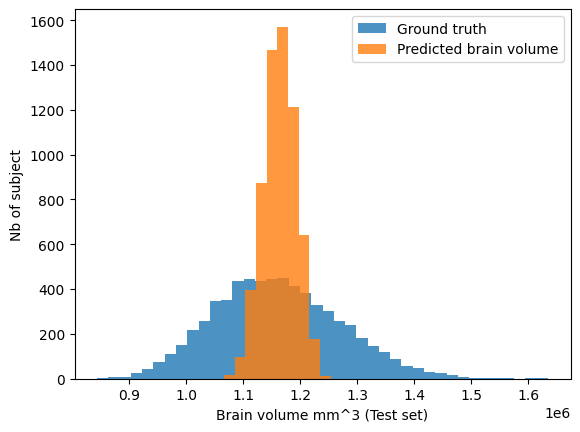

In [59]:
plt.hist(y_test, alpha=0.8, label='Ground truth', bins=40)
plt.hist(ridge_model.predict(X_test), alpha=0.8, label='Predicted brain volume', bins=10)
plt.xlabel('Brain volume mm^3 (Test set)')
plt.ylabel('Nb of subject')
plt.legend()
plt.show()

## Ridge regression for the age

In [58]:
y_age = ukb_fusion['Age']
print(y_age)

X_train, X_test, y_train, y_test = train_test_split(scl_bdd_ukb, y_age, test_size=0.33, random_state=42)

sub-1000021    51.0
sub-1000458    68.0
sub-1000575    64.0
sub-1000606    58.0
sub-1000963    70.0
               ... 
sub-6022449    63.0
sub-6023469    73.0
sub-6023808    68.0
sub-6023847    73.0
sub-6024754    58.0
Name: Age, Length: 19611, dtype: float64


In [8]:
coef, intercept = ridge_regression(X_train, y_train, alpha=200, return_intercept=True)

In [9]:
ridge_model = Ridge(alpha=200)
ridge_model.fit(X_train, y_train)

Ridge(alpha=200)

In [10]:
ridge_model.score(X_train, y_train)

0.023034432944446626

In [11]:
ridge_model.score(X_test, y_test)

0.017498905372701157

The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R² score of 0.0.

In [12]:
ridge_model.predict(X_test)

array([62.30150916, 62.05950109, 62.61037747, ..., 62.12194719,
       62.04728788, 64.01091509])

The model is a very bad predictor of the age.

#### Grid search cv to be sure that's not a model issue

In [15]:
ridge_model = Ridge()
param_grid = {'alpha': [0.1, 1, 10, 100, 200, 300, 400, 500]}
grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

In [16]:
grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Best parameters found:  {'alpha': 1}
Best cross-validation score:  -54.62738841033789


In [17]:
best_ridge_model = grid_search.best_estimator_
y_pred = best_ridge_model.predict(X_test)

In [18]:
best_ridge_model.score(X_train, y_train)

0.053568539070837806

In [19]:
best_ridge_model.score(X_test, y_test)

0.030296470365733463

#### To see how sad this model is

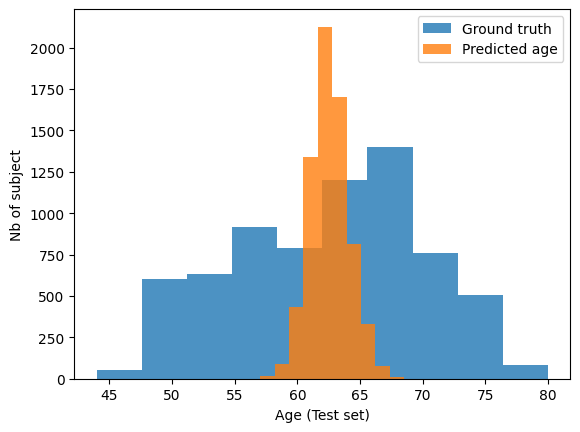

In [23]:
plt.hist(y_test, alpha=0.8, label='Ground truth')
plt.hist(best_ridge_model.predict(X_test), alpha=0.8, label='Predicted age')
plt.xlabel('Age (Test set)')
plt.ylabel('Nb of subject')
plt.legend()
plt.show()